#Simulação de uma rede aberta de filas (MAD)
##Descrição:
O sistema é constituído por três servidores, S1, S2 e S3, cada qual dotado de uma fila ilimitada. Cada job, ao chegar no sistema, precisa ser primeiramente servido por S1. Após concluir o serviço em S1, o job segue com probabilidade 0.5 para o servidor S2, e com probabilidade 0.5 para o servidor S3. Um job que sai do servidor S2 tem probabilidade 0.2 de retornar ao servidor S2 (voltando ao final da fila de S2, se ela não estiver vazia) para receber um novo serviço, independentemente de quantas vezes já tenha passado por S2. Ao sair definitivamente de S2, o job sai do sistema. Da mesma forma, ao sair de S3 (deterministicamente), o job sai do sistema.
As chegadas de jobs ao sistema constituem um processo de Poisson com taxa lambda = 2 jobs por segundo. Ou seja, o tempo entre as chegadas de dois jobs consecutivos é uma V.A. exponencial com média 1/lambda = 0.5 segundos (isto é, uma exponencial com taxa lambda).


###Primeiro passo: Modelagem do sistema
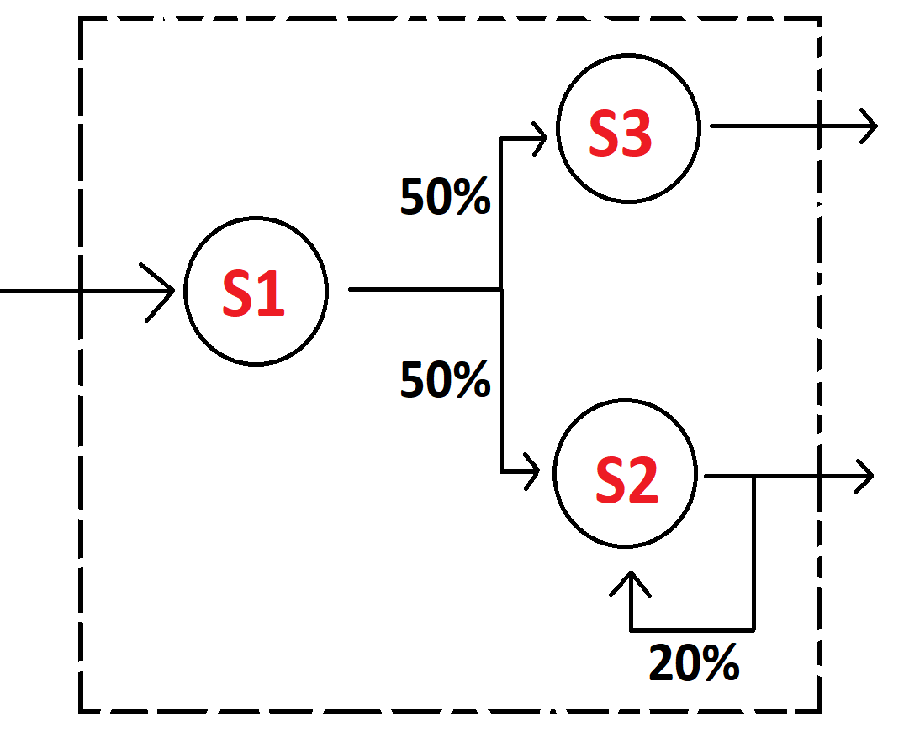

###Segundo passo: código

In [ ]:
import random
import heapq
import statistics

#parâmetros para o cálculo das chegadas
total_jobs = 20000
taxa_lambda = 2

#filas
f1 = []
f2 = []
f3 = []

#controle de eventos
eventos = []
jobs_completos = 0

#métricas
tempos = {}

#função das métricas
def medidas(dict):
  tempos_no_sistema = [saida - chegada for job_id, (chegada, saida) in tempos.items() if job_id >= total_jobs - 10000 and saida is not None]
  media_tempo = statistics.mean(tempos_no_sistema)
  desvio_padrao = statistics.stdev(tempos_no_sistema)

  print(f"Tempo médio no sistema: {media_tempo:.2f} segundos")
  print(f"Desvio padrão do tempo no sistema: {desvio_padrao:.2f} segundos")


#função para cálculo do tempo de chegada absoluto
def calc_chegadas(n_jobs, taxa):
    intervalos = []

    for i in range(n_jobs):
      valor = random.expovariate(taxa)
      intervalos.append(valor)

    chegadas = [0] * n_jobs  #inicializa a lista com valores 0
    chegadas[0] = intervalos[0]

    for i in range(1, n_jobs):  #soma para os valores absolutos
        chegadas[i] = chegadas[i - 1] + intervalos[i]

    return chegadas

#função dos tempos de serviço de acordo com cada situação
def tempo_servico(situacao):
    if situacao == 1:  #situação 1
        return [0.4, 0.6, 0.95]

    elif situacao == 2:  #situação 2
        return [random.uniform(0.1, 0.7), random.uniform(0.1, 1.1), random.uniform(0.1,1.8)]
    elif situacao == 3:  #situação 3
        return [random.expovariate(0.4), random.expovariate(0.6), random.expovariate(0.95)]

#função para controle dos eventos
def controleEventos(tempo, tipo, job_id):
    heapq.heappush(eventos, (tempo, tipo, job_id))

#função dos servidores
def servidor_1(tempo_atual, situacao):
    job_atual = f1.pop(0)
    servico = tempo_servico(situacao)

    if random.random() < 0.5:
        f2.append(job_atual)
        controleEventos(tempo_atual + servico[0], "servidor_2", job_atual)
    else:
        f3.append(job_atual)
        controleEventos(tempo_atual + servico[0], "servidor_3", job_atual)

def servidor_2(tempo_atual, situacao):
    job_atual = f2.pop(0)
    servico = tempo_servico(situacao)

    if random.random() < 0.2:
        f2.append(job_atual)
        controleEventos(tempo_atual + servico[1], "servidor_2", job_atual)
    else:
        global jobs_completos
        jobs_completos += 1
        tempos[job_atual][1] = tempo_atual + servico[1]  #registra tempo de saída

def servidor_3(tempo_atual, situacao):
    job_atual = f3.pop(0)
    servico = tempo_servico(situacao)

    global jobs_completos
    jobs_completos += 1
    tempos[job_atual][1] = tempo_atual + servico[2]  #registra tempo de saída

# Simulação
def simulacao(situacao):
    global jobs_completos

    #gera os tempos de chegada
    chegadas = calc_chegadas(total_jobs, taxa_lambda)

    #cria o primeiro evento de chegada
    controleEventos(chegadas[0], "chegou", 0)

    #controle da lista com os tempos de chegada
    index = 1

    #gera os tempos de serviço iniciais de acordo com a situação
    #servico = tempo_servico(situacao)

    #loop da simulação
    while jobs_completos < total_jobs:
        tempo_atual, tipo, job_id = heapq.heappop(eventos)

        if tipo == "chegou":
            tempos[job_id] = [tempo_atual, None]  #registra o tempo de chegada
            f1.append(job_id)
            if index < total_jobs: #enquanto tiver job pra chegar, gera um evento
                controleEventos(chegadas[index], "chegou", index)
                index += 1
            controleEventos(tempo_atual, "servidor_1", job_id)

        elif tipo == "servidor_1" and f1:
            servidor_1(tempo_atual, situacao)

        elif tipo == "servidor_2" and f2:
            servidor_2(tempo_atual, situacao)

        elif tipo == "servidor_3" and f3:
            servidor_3(tempo_atual, situacao)

    medidas(tempos)

###Terceiro passo: simulando para cada situação
- Situação 1: os tempos de serviço são fixos, determinísticos, e iguais a 0.4s, 0.6s e 0.95s, respectivamente.
- Situação 2: os tempos de serviço nos três servidores são V.A.s uniformes nos intervalos (0.1, 0.7), (0.1, 1.1) e (0.1, 1.8), respectivamente.
- Situação 3: os tempos de serviço são V.A.s exponenciais com médias 0.4s, 0.6s e 0.95s, respectivamente.

In [ ]:
#1 = situação 1, tempos fixos
#2 = situação 2, distribuição uniforme
#3 = situação 3, distribuição exponencial

simulacao(3)

Tempo médio no sistema: 4.08 segundos
Desvio padrão do tempo no sistema: 2.19 segundos


###Observações:
O tempo médio de um job no sistema das situações 1 e 2 são semelhantes, porém o desvio padrão dos jobs com tempo de serviço variando em um intervalo de distribuição uniforme (situação 2) é praticamente o dobro da situação 1. Isso se deve pelo fato de que a distribuição uniforme introduz uma maior variabilidade nos tempos de serviço. Ainda sim, apesar da distribuição uniforme gera essa maior variabilidade, os tempos de serviço ainda estão relativamente próximos uns dos outros o que torna o tempo médio de um job em ambos os sistemas bastante semelhantes.

Enquanto isso, na situação 3, o tempo médio no sistema é bem mais alto, assim como o desvio padrão. Isso ocorre porque a distribuição exponencial vai gerar tempos de serviços mais altos, aumentando a variabilidade de maneira não pré-definida como é no intervalo uniforme ou nos tempos fixos. Essa variabilidade introduzida pela variável exponencial acaba gerando filas mais longas.